In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import os

In [30]:
# Data loading
path = r'../data/interim/data_v1.csv'
alzheimer_v1_df = pd.read_csv(path)

In [31]:
alzheimer_v1_df.head(10)

,Año,Semana,Fecha,Entidad,Año_Epi,H,M,Sem.
0,2014,2,2014-01-13,Aguascalientes,2014,0.0,0.0,0.0
1,2014,3,2014-01-20,Aguascalientes,2014,0.0,0.0,0.0
2,2014,4,2014-01-27,Aguascalientes,2014,0.0,0.0,0.0
3,2014,5,2014-02-03,Aguascalientes,2014,0.0,0.0,0.0
4,2014,6,2014-02-10,Aguascalientes,2014,0.0,0.0,0.0
5,2014,7,2014-02-17,Aguascalientes,2014,0.0,0.0,0.0
6,2014,8,2014-02-24,Aguascalientes,2014,0.0,0.0,0.0
7,2014,9,2014-03-03,Aguascalientes,2014,0.0,0.0,0.0
8,2014,10,2014-03-10,Aguascalientes,2014,0.0,0.0,0.0
9,2014,11,2014-03-17,Aguascalientes,2014,0.0,0.0,0.0


## Fixing Inconsistencies

In [32]:
alzheimer_df = alzheimer_v1_df.copy()

# Ordenar por entidad y tiempo
df = alzheimer_df.sort_values(['Entidad', 'Año', 'Semana']).reset_index(drop=True)

# 1. DETECTAR DECREMENTOS (errores críticos)
df['H_anterior'] = df.groupby('Entidad')['H'].shift(1)
df['M_anterior'] = df.groupby('Entidad')['M'].shift(1)

# Calcular diferencias
df['H_diff'] = df['H'] - df['H_anterior']
df['M_diff'] = df['M'] - df['M_anterior']

# Identificar decrementos (excluyendo semana 2 que es reinicio natural)
df['H_decremento'] = (df['H_diff'] < 0) & (df['Semana'] != 2)
df['M_decremento'] = (df['M_diff'] < 0) & (df['Semana'] != 2)
df['Tiene_decremento'] = df['H_decremento'] | df['M_decremento']

print("="*60)
print("PASO 1: DETECCIÓN DE DECREMENTOS")
print("="*60)
print(f"Decrementos en H: {df['H_decremento'].sum()}")
print(f"Decrementos en M: {df['M_decremento'].sum()}")
print(f"Total registros con decrementos: {df['Tiene_decremento'].sum()}")

# Ver ejemplos
if df['Tiene_decremento'].sum() > 0:
    print("\nEjemplos de decrementos:")
    ejemplos = df[df['Tiene_decremento']][['Entidad', 'Año', 'Semana', 'H', 'M', 'H_diff', 'M_diff']].head(10)
    print(ejemplos)

# 2. DETECTAR SALTOS ANORMALES (como en tu ejemplo)
# Calcular el incremento semanal promedio y desviación por entidad
stats_entidad = df.groupby('Entidad').agg({
    'H_diff': ['mean', 'std'],
    'M_diff': ['mean', 'std']
}).reset_index()

stats_entidad.columns = ['Entidad', 'H_diff_mean', 'H_diff_std', 'M_diff_mean', 'M_diff_std']

# Unir estadísticas al dataframe
df = df.merge(stats_entidad, on='Entidad', how='left')

# Detectar saltos anormales (más de 3 desviaciones estándar del promedio)
umbral = 3
df['H_salto_anormal'] = (
    (df['H_diff'] > df['H_diff_mean'] + umbral * df['H_diff_std']) &
    (df['Semana'] != 2)
)
df['M_salto_anormal'] = (
    (df['M_diff'] > df['M_diff_mean'] + umbral * df['M_diff_std']) &
    (df['Semana'] != 2)
)
df['Tiene_salto_anormal'] = df['H_salto_anormal'] | df['M_salto_anormal']

print("\n" + "="*60)
print("PASO 2: DETECCIÓN DE SALTOS ANORMALES")
print("="*60)
print(f"Saltos anormales en H: {df['H_salto_anormal'].sum()}")
print(f"Saltos anormales en M: {df['M_salto_anormal'].sum()}")
print(f"Total registros con saltos: {df['Tiene_salto_anormal'].sum()}")

# Ver ejemplos
if df['Tiene_salto_anormal'].sum() > 0:
    print("\nEjemplos de saltos anormales:")
    ejemplos_saltos = df[df['Tiene_salto_anormal']][
        ['Entidad', 'Año', 'Semana', 'H', 'M', 'H_diff', 'M_diff']
    ].head(10)
    print(ejemplos_saltos)

# 3. RESUMEN COMBINADO
df['Error_detectado'] = df['Tiene_decremento'] | df['Tiene_salto_anormal']

print("\n" + "="*60)
print("RESUMEN TOTAL DE ERRORES")
print("="*60)
print(f"Total de registros con errores: {df['Error_detectado'].sum()}")
print(f"Porcentaje de datos con errores: {(df['Error_detectado'].sum() / len(df)) * 100:.2f}%")

# Errores por entidad
errores_por_entidad = df[df['Error_detectado']].groupby('Entidad').size().sort_values(ascending=False)
print("\nTop 10 entidades con más errores:")
print(errores_por_entidad.head(10))


PASO 1: DETECCIÓN DE DECREMENTOS
Decrementos en H: 94
Decrementos en M: 112
Total registros con decrementos: 134

Ejemplos de decrementos:
                  Entidad   Año  Semana     H     M  H_diff  M_diff
95         Aguascalientes  2015      44   3.0   9.0     0.0    -1.0
124        Aguascalientes  2016      21   5.0   9.0   -12.0    -9.0
249        Aguascalientes  2018      42   9.0  14.0    -1.0     1.0
549        Aguascalientes  2024      30   5.0   7.0     0.0    -1.0
606       Baja California  2014      36  20.0  47.0     0.0    -2.0
696       Baja California  2016      21  19.0  27.0   -24.0   -17.0
888       Baja California  2020       5   4.0   4.0     1.0    -1.0
920       Baja California  2020      37  15.0  33.0     0.0    -1.0
1238  Baja California Sur  2015      43   5.0   9.0     0.0    -1.0
1268  Baja California Sur  2016      21   6.0   3.0    -5.0    -3.0

PASO 2: DETECCIÓN DE SALTOS ANORMALES
Saltos anormales en H: 31
Saltos anormales en M: 28
Total registros con sa

In [33]:
def corregir_con_ventana_deslizante(df, ventana=3, umbral_std=2.5):
    """
    Detecta outliers usando estadísticas de ventana deslizante.
    """
    df_corregido = df.copy()
    df_corregido['H_corregido'] = df_corregido['H'].copy()
    df_corregido['M_corregido'] = df_corregido['M'].copy()
    
    for entidad in df_corregido['Entidad'].unique():
        mask = df_corregido['Entidad'] == entidad
        df_entidad = df_corregido[mask].sort_values(['Año', 'Semana']).copy()
        indices = df_entidad.index
        
        # Calcular incrementos
        df_entidad['H_incremento'] = df_entidad['H'].diff()
        df_entidad['M_incremento'] = df_entidad['M'].diff()
        
        # PASADA 1: Detectar outliers en incrementos
        for i in range(ventana, len(df_entidad) - 1):
            if df_entidad.iloc[i]['Semana'] == 2:
                continue
            
            idx_actual = indices[i]
            
            # Ventana de contexto (excluir punto actual)
            ventana_antes = df_entidad.iloc[i-ventana:i]
            
            # Estadísticas de incrementos en la ventana
            h_inc_mean = ventana_antes['H_incremento'].mean()
            h_inc_std = ventana_antes['H_incremento'].std()
            
            m_inc_mean = ventana_antes['M_incremento'].mean()
            m_inc_std = ventana_antes['M_incremento'].std()
            
            # Incremento actual
            h_inc_actual = df_entidad.iloc[i]['H_incremento']
            m_inc_actual = df_entidad.iloc[i]['M_incremento']
            
            # Detectar outlier en H
            if h_inc_std > 0:
                z_score_h = abs((h_inc_actual - h_inc_mean) / h_inc_std)
                if z_score_h > umbral_std:
                    # Es un outlier, interpolar
                    h_ant = df_corregido.loc[indices[i-1], 'H_corregido']
                    h_sig = df_entidad.iloc[i+1]['H']
                    df_corregido.loc[idx_actual, 'H_corregido'] = (h_ant + h_sig) / 2
            
            # Detectar outlier en M
            if m_inc_std > 0:
                z_score_m = abs((m_inc_actual - m_inc_mean) / m_inc_std)
                if z_score_m > umbral_std:
                    m_ant = df_corregido.loc[indices[i-1], 'M_corregido']
                    m_sig = df_entidad.iloc[i+1]['M']
                    df_corregido.loc[idx_actual, 'M_corregido'] = (m_ant + m_sig) / 2
        
        # PASADA 2: Corregir decrementos
        for i in range(1, len(indices)):
            idx_actual = indices[i]
            idx_anterior = indices[i-1]
            
            if df_corregido.loc[idx_actual, 'Semana'] == 2:
                continue
            
            if df_corregido.loc[idx_actual, 'H_corregido'] < df_corregido.loc[idx_anterior, 'H_corregido']:
                df_corregido.loc[idx_actual, 'H_corregido'] = df_corregido.loc[idx_anterior, 'H_corregido']
            
            if df_corregido.loc[idx_actual, 'M_corregido'] < df_corregido.loc[idx_anterior, 'M_corregido']:
                df_corregido.loc[idx_actual, 'M_corregido'] = df_corregido.loc[idx_anterior, 'M_corregido']
    
    df_corregido['H_fue_corregido'] = (df_corregido['H'] != df_corregido['H_corregido'])
    df_corregido['M_fue_corregido'] = (df_corregido['M'] != df_corregido['M_corregido'])
    
    return df_corregido

# Aplicar método de ventana deslizante
df_limpio = corregir_con_ventana_deslizante(df, ventana=3, umbral_std=2.5)


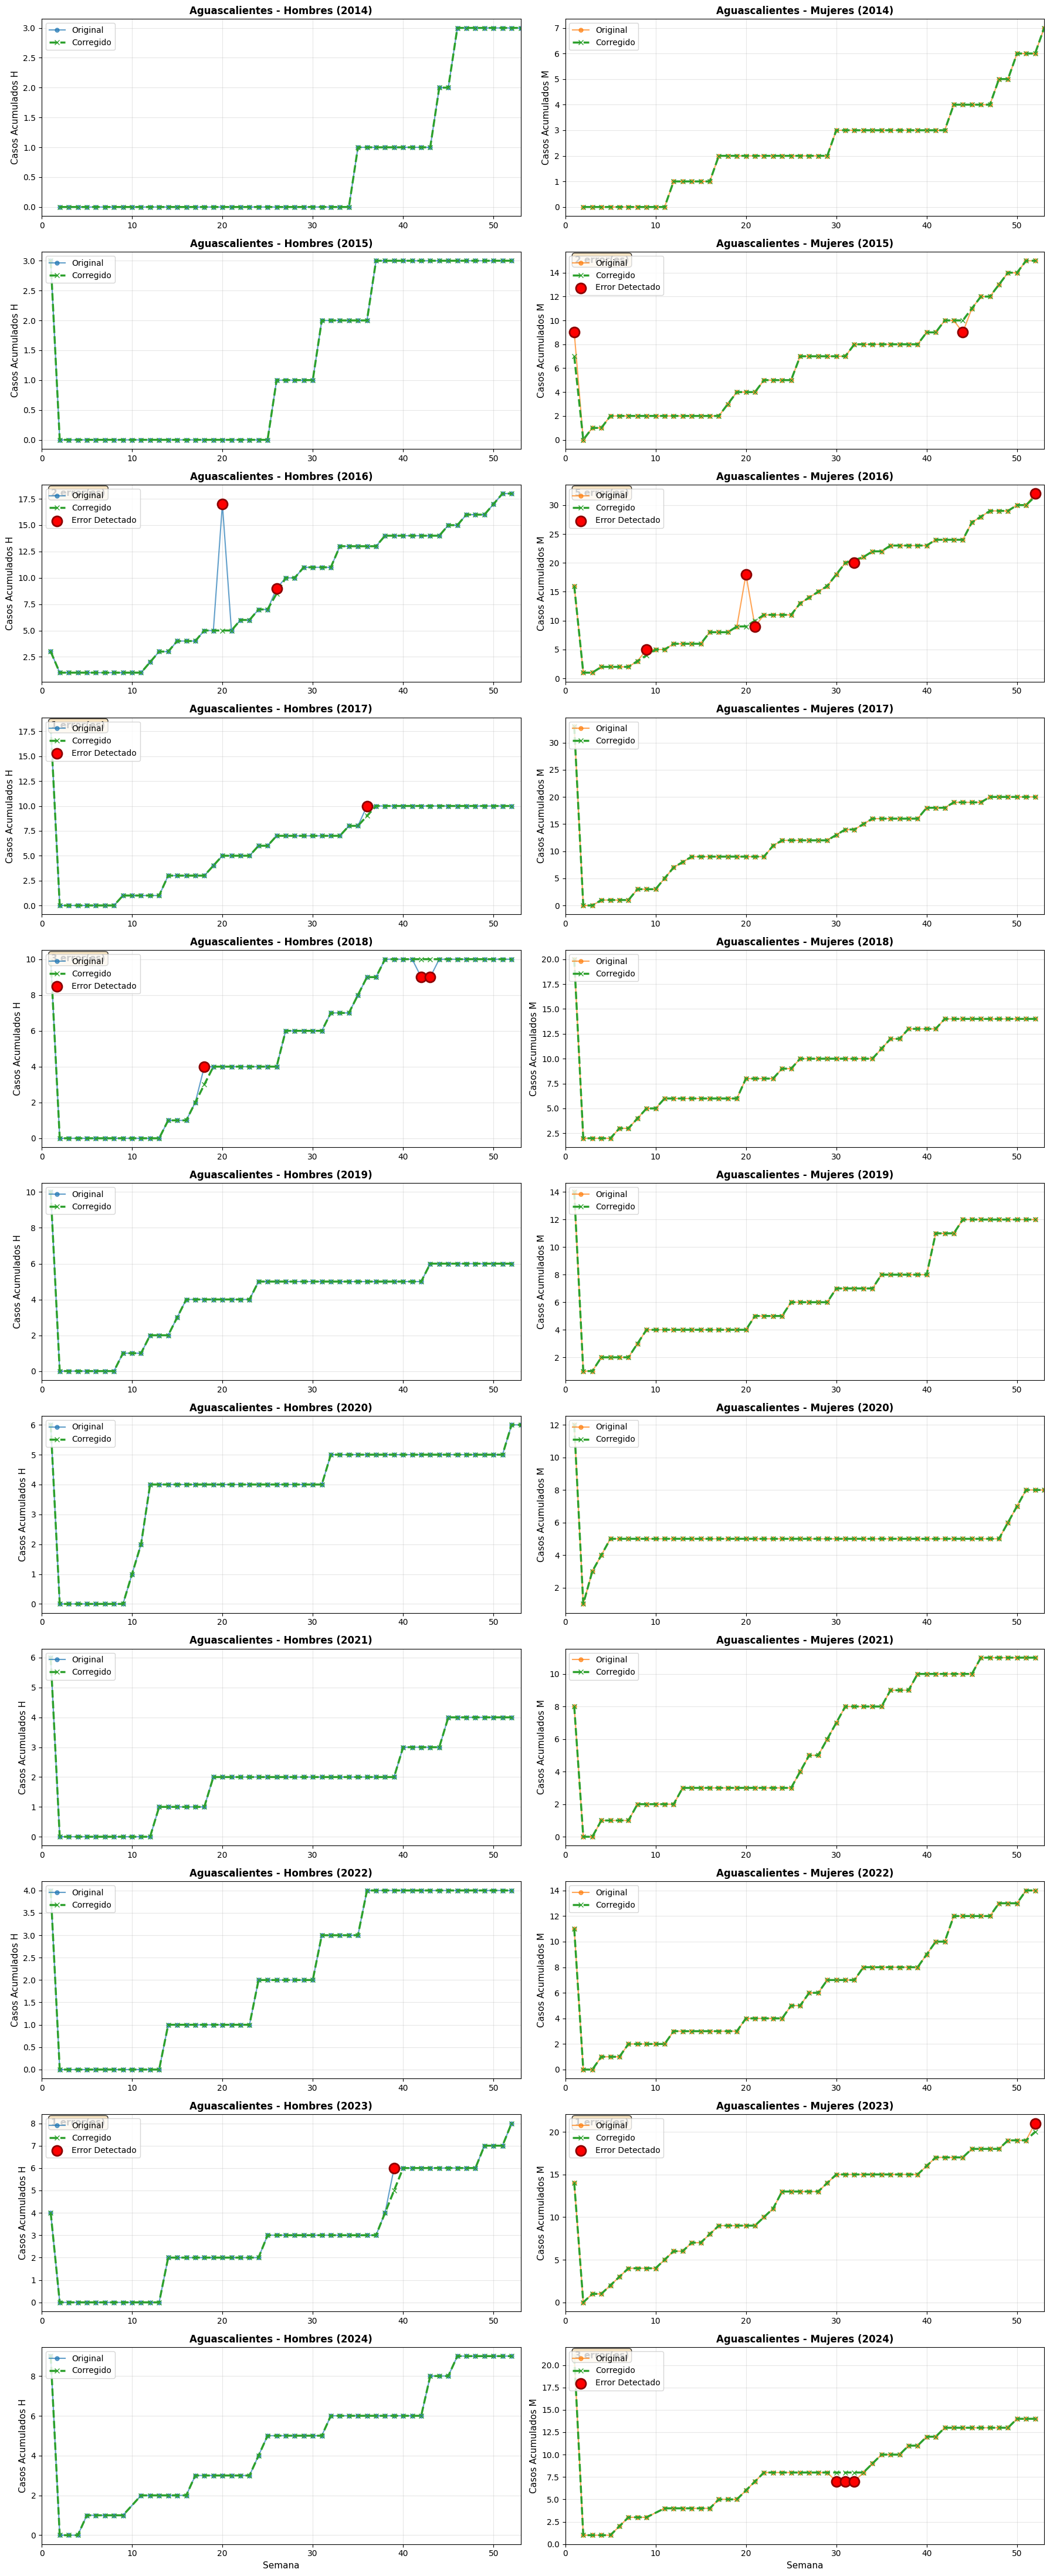


Resumen de correcciones para Aguascalientes:
--------------------------------------------------
Año 2014: 0 errores en H, 0 errores en M
Año 2015: 0 errores en H, 2 errores en M
Año 2016: 2 errores en H, 5 errores en M
Año 2017: 1 errores en H, 0 errores en M
Año 2018: 3 errores en H, 0 errores en M
Año 2019: 0 errores en H, 0 errores en M
Año 2020: 0 errores en H, 0 errores en M
Año 2021: 0 errores en H, 0 errores en M
Año 2022: 0 errores en H, 0 errores en M
Año 2023: 1 errores en H, 1 errores en M
Año 2024: 0 errores en H, 3 errores en M


In [34]:
import matplotlib.pyplot as plt

def visualizar_correcciones_por_año(df_original, df_corregido, entidad):
    """
    Visualiza H y M antes y después de correcciones, dividido por año.
    """
    mask = df_original['Entidad'] == entidad
    df_orig = df_original[mask].copy()
    df_corr = df_corregido[mask].copy()
    
    años = sorted(df_orig['Año'].unique())
    n_años = len(años)
    
    # Crear subplots: 2 columnas (H y M) x n_años filas
    fig, axes = plt.subplots(n_años, 2, figsize=(18, 4*n_años))
    
    # Si solo hay un año, axes no será un array 2D
    if n_años == 1:
        axes = axes.reshape(1, -1)
    
    for idx, año in enumerate(años):
        df_orig_año = df_orig[df_orig['Año'] == año]
        df_corr_año = df_corr[df_corr['Año'] == año]
        
        # Gráfico H (columna izquierda)
        ax_h = axes[idx, 0]
        ax_h.plot(df_orig_año['Semana'], df_orig_año['H'], 
                  'o-', label='Original', markersize=5, alpha=0.7, color='#1f77b4')
        ax_h.plot(df_corr_año['Semana'], df_corr_año['H_corregido'], 
                  'x--', label='Corregido', markersize=6, linewidth=2.5, color='#2ca02c')
        
        # Marcar correcciones en H
        correcciones_h = df_corr_año[df_corr_año['H_fue_corregido']]
        if len(correcciones_h) > 0:
            ax_h.scatter(correcciones_h['Semana'], correcciones_h['H'], 
                        color='red', s=150, zorder=5, marker='o', 
                        edgecolors='darkred', linewidth=2, label='Error Detectado')
            
            # Añadir contador de errores
            n_errores = len(correcciones_h)
            ax_h.text(0.02, 0.98, f'{n_errores} error(es)', 
                     transform=ax_h.transAxes, fontsize=11, weight='bold',
                     verticalalignment='top', 
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax_h.set_ylabel('Casos Acumulados H', fontsize=11)
        ax_h.set_title(f'{entidad} - Hombres ({año})', fontsize=12, weight='bold')
        ax_h.legend(loc='upper left', fontsize=10)
        ax_h.grid(True, alpha=0.3)
        ax_h.set_xlim(0, 53)
        
        # Gráfico M (columna derecha)
        ax_m = axes[idx, 1]
        ax_m.plot(df_orig_año['Semana'], df_orig_año['M'], 
                  'o-', label='Original', markersize=5, alpha=0.7, color='#ff7f0e')
        ax_m.plot(df_corr_año['Semana'], df_corr_año['M_corregido'], 
                  'x--', label='Corregido', markersize=6, linewidth=2.5, color='#2ca02c')
        
        # Marcar correcciones en M
        correcciones_m = df_corr_año[df_corr_año['M_fue_corregido']]
        if len(correcciones_m) > 0:
            ax_m.scatter(correcciones_m['Semana'], correcciones_m['M'], 
                        color='red', s=150, zorder=5, marker='o',
                        edgecolors='darkred', linewidth=2, label='Error Detectado')
            
            # Añadir contador de errores
            n_errores = len(correcciones_m)
            ax_m.text(0.02, 0.98, f'{n_errores} error(es)', 
                     transform=ax_m.transAxes, fontsize=11, weight='bold',
                     verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax_m.set_ylabel('Casos Acumulados M', fontsize=11)
        ax_m.set_title(f'{entidad} - Mujeres ({año})', fontsize=12, weight='bold')
        ax_m.legend(loc='upper left', fontsize=10)
        ax_m.grid(True, alpha=0.3)
        ax_m.set_xlim(0, 53)
        
        # Añadir etiqueta de semana solo en la última fila
        if idx == n_años - 1:
            ax_h.set_xlabel('Semana', fontsize=11)
            ax_m.set_xlabel('Semana', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Resumen de correcciones
    total_h = df_corr[df_corr['H_fue_corregido']].groupby('Año').size()
    total_m = df_corr[df_corr['M_fue_corregido']].groupby('Año').size()
    
    print(f"\nResumen de correcciones para {entidad}:")
    print("-" * 50)
    for año in años:
        n_h = total_h.get(año, 0)
        n_m = total_m.get(año, 0)
        print(f"Año {año}: {n_h} errores en H, {n_m} errores en M")

# Uso
entidades_con_errores = df[df['Error_detectado']]['Entidad'].unique()
if len(entidades_con_errores) > 0:
    visualizar_correcciones_por_año(df, df_limpio, entidades_con_errores[0])


In [35]:
df_limpio_v1 = df_limpio[['Año', 'Semana', 'Fecha', 'Entidad', 'Año_Epi','H', 'M']].copy()

output_folder = '../data/processed/'
filename = 'data_processed_v1.csv'
route = os.path.join(output_folder, filename)


df_limpio_v1.to_csv(
    route,
    index=False,
    encoding='utf-8'
)

In [36]:
df_limpio_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18304 entries, 0 to 18303
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Año      18304 non-null  int64  
 1   Semana   18304 non-null  int64  
 2   Fecha    18304 non-null  object 
 3   Entidad  18304 non-null  object 
 4   Año_Epi  18304 non-null  int64  
 5   H        18304 non-null  float64
 6   M        18304 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 1001.1+ KB
